In [1]:
# Librerías a utilizar

import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt  
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Importar datos 

El repositorio de Github "nflverse" en la carpeta "nflverse-data" contiene archivos csv comprimidos que contiene el jugada a jugada de todas las temporadas desde 1999 de la National Football League.

Ls primeras líneas de código que utilizaremos será para descargar y apilar dichos datsets.

In [2]:

#Código para descargar las últimas 10 temporadas completas de la NFL
YEARS = range(2012,2022) #Rango 2012-2021


#la función for nos arroja el rango de años que queremos utilizar 
#usaremos la función append para unir la información y ordenarla por año
data = pd.DataFrame()

for i in YEARS:  
    i_data = pd.read_csv('https://github.com/nflverse/nflverse-data/releases/download/pbp/' \
                   'play_by_play_' + str(i) + '.csv.gz',
                   compression= 'gzip', low_memory= False)
    data = data.append(i_data, sort=True)

# Filas y columnas

En el período señalado, contamos con 486,293 jugadas y hay 372 posibles variables

In [3]:
data.shape

(486293, 372)

# Limpieza de datos

- El primer paso es hacer un pequeño ajuste; hay jugadas que el QB retrocede para lanzar (dropback, de aquí en delante) y termina escapándose de la bolsa de protección, lo que en inglés se conoce como "quaterback scramble". Ese tipo de jugadas se contabilizan como acarreos, cuando en realidad son jugadas de pase, hay que localizarlas y ajustarlas.

In [3]:
# Creamos un nuevo data frame y hacemos los ajustes

data1 = data.copy()

# Localizamos todas las jugadas de pase y nos aseguramos que se contabilizen como pases

data1.loc[data1['pass']== 1, 'play_type']== 'pass'

# Localizamos todas las jugadas de corrida y nos aseguramos que se contabilizen como acarreos

data1.loc[data1['rush']== 1, 'play_type']== 'run'

data1.shape

(486293, 372)

# Limpieza de datos (cont.) y definición de variables.

- Variables que utilizaremos en el notebook:
    - play_type: indican el tipo de acción de la jugada:
        - pass: indica que hubo un intento de pase en la jugada, incluye:
            - Intento de pases
                - Completos
                - Incompletos
            - Capturas de QB
            - Escapes de QB (scramble): Es cuando el QB retrocede para lanzar, pero termina acarreando el balón.
        - run: indica que hubo un acarreo en la jugada, incluye:
        - no_play: indica que la jugada fue eliminada por un castigo o tiempo fuera.
        - qb_kneel: indica que el QB puso rodilla en tierra para terminarse el tiempo de juego.
        - field_goal: indica que hubo un intento de gol de campo.
        - punt: indica que hubo un  despeje.
        - qb_spike: el qb azota el balón en el piso para detener el reloj de juego.
        - missing: se utiliza para señalar el fin de un cuarto, mitad o juego.
    - pass: variable binaria que contabiliza los intentos de pase:
        - intentos de pase.
        - escapes de quatrback.
        - capturas de quaterback.
        - conversiones de 2 pt intentadaas con pases.
    - rush: variable binaria que contabiliza los acarreos en el juego:
        - acarreos durante el juego.
        - conversiones de 2pt intentadas con acarreos.
    - ep (expected points): métrica que indica la cantidad de puntos que se espera anote el equipo con la posesión del balón, basdo en su ubicación en el terreno del juego y tiempo disponible:
        - La diferencia que hay entre el ep previo a la ejecucción de laa jugada y el ep posterior se conoce como Expected Points Added (EP) y es una de las métricas de eficiencia más utilizadas.
    - season_type: variable que indica la fase donde se disput el juego:
        - REG: Temporada regular
        - POST: Playoffs
    - two_point_attempt: variable binaria que indica si hubo un intento de conversión de dos puntos en la jugada.

In [378]:
# Nuestro nuevo dataframe solo incluirá eel tipo de jugdas: pass, run & no_play
# Eliminaremos las jugadas que no contengan datos de epa, pues suelen ser tiempos fuera, kneeldowns y finalizaciones de cuartos, mitad o juego
# Nos limitaremos a jugadas dentro del desarollo de juego, en la faase regular del campeonato

data1 = data1[(data1['play_type'].isin(['pass', 
                                        'run', 
                                        'no_play'])) &
              (data1.epa.isna()==False) &
              (data1['two_point_attempt']==0)&
              (data1['season_type']=='REG')]

data1.shape

(367108, 372)

# Contabilización de jugadas por tipo

- El cambio de reglas como el enfásis en los castigos defensivos como sujetando (holding), interferencia de pase ( defensive pass interference) y rudeza innecesaria contra el pasador han influenciado a los equipos a llamar más jugadas de pase

- Del 2012 al 2021, los equipos de la NFL han llamado 201,014 jugadas de pase por 139,123 acarreos

Text(0.5, 1.0, 'Los equipos de la NFL han llamado un 44% más pases que acarreos')

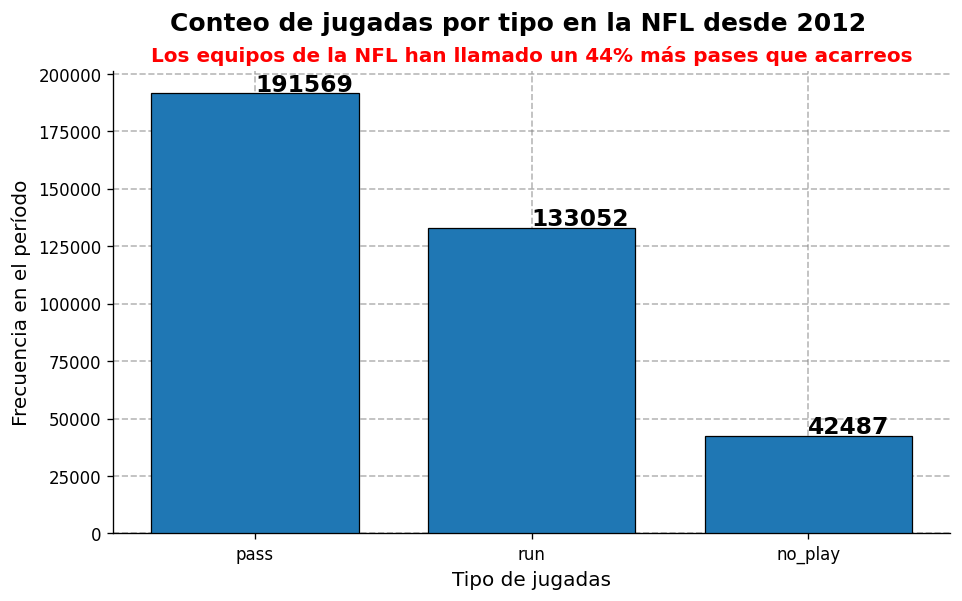

In [380]:
# Nuevo dataframe para gráficar el número de jugadas y su eficiencia. 

plot = data1.groupby('play_type').agg(Veces = ('play_type', 'count')).reset_index().sort_values(by='Veces', ascending=False)

times = plot['Veces'].reset_index(drop=True)
tipo = plot['play_type'].reset_index(drop=True)

#Figura donde se insertara la grafica
fig= plt.figure(figsize= (9,5), dpi= 120)
ax= plt.subplot(111, facecolor= "white")

# Formato del contorno de figura y líneas de división de ejes
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.grid(lw = 1, color = "grey", ls='--', alpha=0.55)

# Gráfico de barras
ax.bar(tipo, times, ec="black", lw=0.75, zorder=3, width=0.75)

# Código para insertar el número de veces en cada barra.
for i, text in enumerate(times):
    ax.annotate(text, (tipo[i], times[i]+1000),fontweight='bold', fontsize=14)
    

# Títulos de los ejes.    
ax.set_xlabel('Tipo de jugadas', fontsize=12)
ax.set_ylabel('Frecuencia en el período', fontsize=12)

# Título de la figura
fig.suptitle(t='Conteo de jugadas por tipo en la NFL desde 2012',fontsize=15, fontweight='bold')

# Título de la gráfica

ax.set_title(label='Los equipos de la NFL han llamado un 44% más pases que acarreos', fontsize=12, fontweight='bold',color='red')

# Contabilización de jugadas, parte II

- Para probar que este cambio no es un producto de unas pocas temporadas en el período, graficamos el porcentaje de pases que llaman los equipos por temporada:
  - Se observa que la tasa de pases por partido es muy estable en 60-62 %
  - Promedio: 61.3 %
  - Desviación estándar: 0.61 %

Text(0.5, 0, 'Temporada')

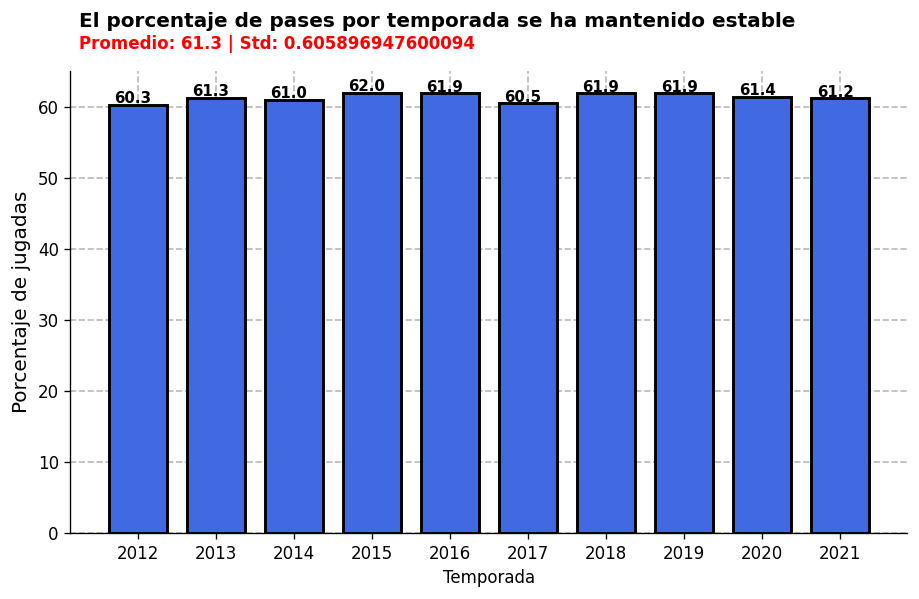

In [384]:
# Tendencias de llamadas por temporada, eliminando jugadas que se cancelaron por castigo

plot = data1[~(data1['play_type']=='no_play')]

# Porcentaje de pases por temporada

pases_tend = ((plot.groupby('season')['pass'].mean().reset_index(drop=True))*100).round(1)

x = pd.Series(range(len(pases_tend)))
labels = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

#Figura donde se insertara la grafica
fig= plt.figure(figsize= (9,5), dpi= 120)
ax= plt.subplot(111, facecolor= "white")

# Formato del contorno de figura y líneas de división de ejes
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.grid(lw = 1, color = "grey", ls='--', alpha=0.55)

# Gráfico de barras

ax.bar(x, # Variable X 
       pases_tend, # Variable Y 
       color='royalblue',
       ec ='black',
       lw=1.75, 
       zorder=3, 
       width=0.75) # Grueso de la línea de contorno del marcador

# Cambiar esacala original por nombres

ax.set_xticklabels(labels=labels)

# Introducir nombre de la variable

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))


# Código para insertar el número de veces en cada barra.
for i, text in enumerate(pases_tend):
    ax.annotate(text, (x[i]-0.3, pases_tend[i]+0.25),fontweight='bold', fontsize=9)

# Código para incluir título

ax.text(x.min()-0.75, pases_tend.max()*1.15,s='El porcentaje de pases por temporada se ha mantenido estable', fontsize=12, fontweight='bold')
ax.text(x.min()-0.75, pases_tend.max()*1.10, s=f"Promedio: {pases_tend.mean().round(1)} | Std: {pases_tend.std()}",color='red', fontweight='bold')

ax.set_ylabel('Porcentaje de jugadas', fontsize=12)
ax.set_xlabel('Temporada')

# Contabilización de jugadas, parte III

- Otra manera de visualizar el dominio de ls jugadas por pase es hacer histogramas
    - Si empalmamos los dos histogramas en la gráfica, podemos observar que ambos histogramas se comportan de forma similar a una distribución normal.
    - La media de acarreos por ofensiva en un juego es de 24.3, mientras que la media de pases por ofensiva por juego es de 38.7
    

Text(0, 750, 'Prom. de pases por partido: 38.7 | Prom. de acarreos por partido: 24.3')

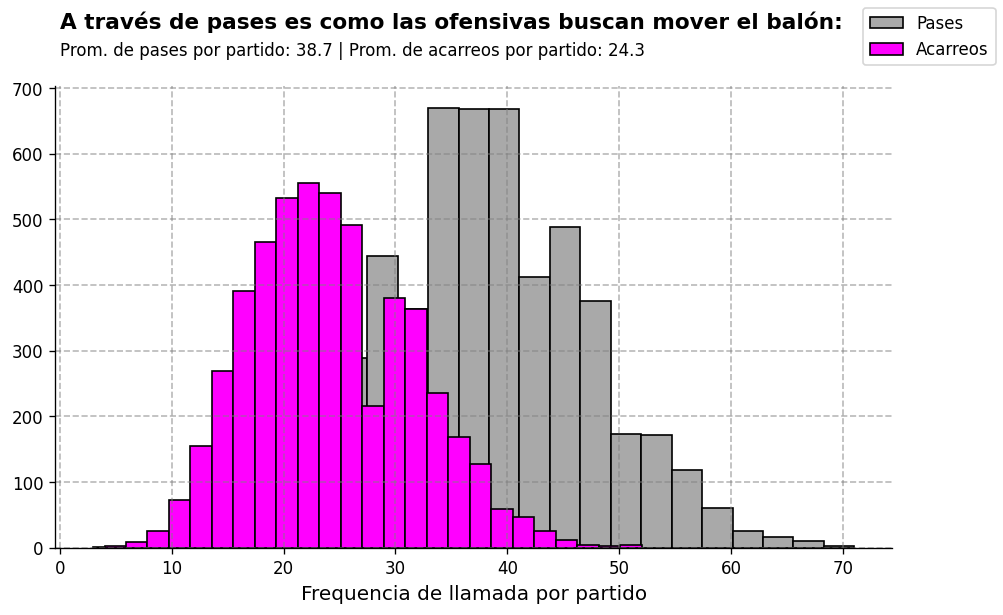

In [385]:
# Jugadas por juego

# Agrupar por juego, ofensiva, eliminando los castigos
plot = data1[~(data1['play_type']=='no_play')].groupby(['game_id',
                                                       'posteam']).agg(pases=('pass', 'sum'),
                                                                       rushes = ('rush', 'sum')).reset_index()

# Jugadas de pase por juego
pases_freq = plot['pases']

# Jugadas de acarreo por juego
rushes_freq = plot['rushes']



#Figura donde se insertara la grafica
fig= plt.figure(figsize= (9,5), dpi= 120)
ax= plt.subplot(111, facecolor= "white")

# Formato del contorno de figura y líneas de división de ejes
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.grid(lw = 1, color = "grey", ls='--', alpha=0.55)

ax.hist(pases_freq, bins=25, ec='black', color='darkgrey')
ax.hist(rushes_freq, bins=25, ec='black', color='magenta')
ax.set_xlabel('Frequencia de llamada por partido', fontsize=12)
fig.legend(['Pases', 'Acarreos'],)

ax.text(0, 790, s= 'A través de pases es como las ofensivas buscan mover el balón:', color='black', fontsize=13, fontweight='bold')
ax.text(0, 750, s= f"Prom. de pases por partido: {pases_freq.mean().round(1)} | Prom. de acarreos por partido: {rushes_freq.mean().round(1)}")

# Eficiencia por jugada

- Expected Points es la cantidad de puntos que esperamos que anote un equipo, dependiendo su ubicación en el terreno de juego; Expected Points Added (EPA) es la diferencia de los EP previo a la jugada y posterior a la jugada.

- Con un boxplot podemos visualizar, algunas de las principales estadísticas descriptivas:
    - Mediana
    - Cuartiles 1 (25%) y 3 (75%)
    - Outliers

- Los pases en promedio son más eficientes que los acarreos, pero también son más volátiles:
    - Cuando se completa un pase se suelen avanzar más yardas.
    - Por el otro lado, hay 3 escenarios negativos al intentar un pase:
        - Pase incompleto
        - Pérdida de yardas vía captura de QB
        - Pase interceptado

Text(0.5, 0, 'Expectd Points Added')

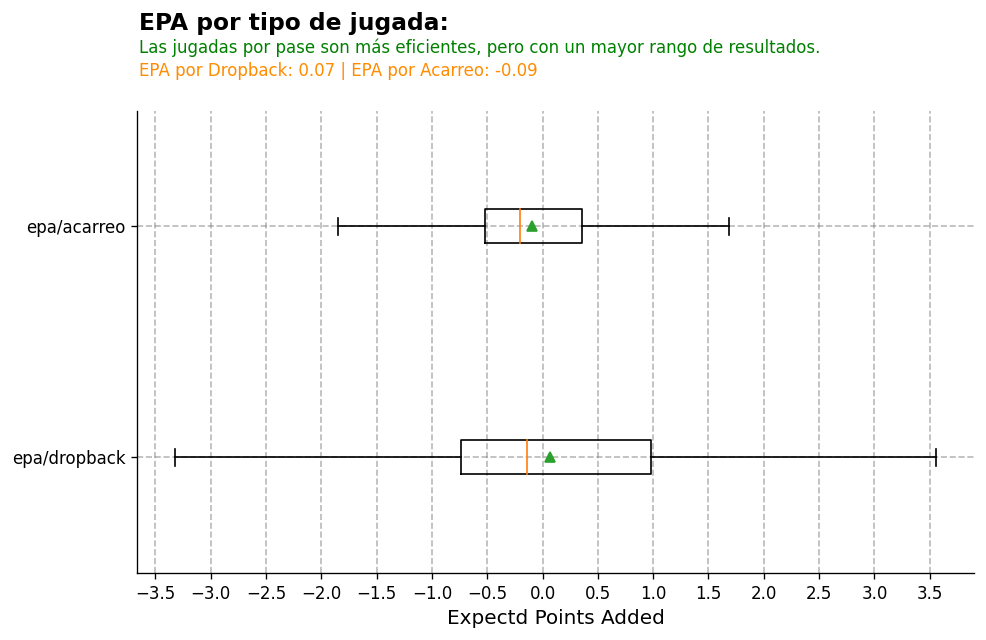

In [386]:
#Figura donde se insertara la grafica
fig= plt.figure(figsize= (9,5), dpi= 120)
ax= plt.subplot(111, facecolor= "white")

# Formato del contorno de figura y líneas de división de ejes
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.grid(lw = 1, color = "grey", ls='--', alpha=0.55)

# Creamos una variable que nos permite, si lo deseamos instalar filtros, sin modificar el dataframe original

plot = data1

# Creamos otra variable para alimentar el boxplot

epa = ((plot[plot['pass']==1]['epa']), (plot[plot['rush']==1]['epa']))

# Nombres de las etiquetas de las diagramas de cajaa y bigote

label = ['epa/dropback', 'epa/acarreo']

# Gráfica de diagrama de caja y bigote; eliminamos los outliers (showfliers) para custiones e escala

ax.boxplot(epa, labels=label, vert=False, showmeans= True, showfliers=False)

# Le damos formato a las marcas de grduación

ax.set_xticks(np.arange(-3.5,4,0.5))

# Instalamos texto para títulos & subtítulos

ax.text(-3.65,2.85, s='EPA por tipo de jugada:', fontsize=14, fontweight='bold')
ax.text(-3.65,2.75, s='Las jugadas por pase son más eficientes, pero con un mayor rango de resultados.', fontsize=10, color='green')
ax.text(-3.65,2.65, s=f"EPA por Dropback: {plot[plot['pass']==1]['epa'].mean().round(2)} | EPA por Acarreo: {plot[plot['rush']==1]['epa'].mean().round(2)}", color='darkorange', fontsize=10)

# Nombre del eje X

ax.set_xlabel('Expectd Points Added', fontsize=12)


# Eficiencia por jugada, parte II

 - En el gráfico de caja y bigotes anterior, podemos observar que los pases, en promedio, son más eficientes que los acarreos; sin embargo, la volatilidad de la eficiencia (riesgo) también es superior:
     - El 25% de los acarreos producen un EPA inferior a -0.52, mientras que el 25% de los pases producen un EPA inferior a -0.74.
         - Como se puede apreciar, las consecuencias negativas de un pase tienen mayor impacto que las consecuencias negativas de un acarreo.
     - El 50% de los acarreos producen un EPA inferior a -0.20, mientras que el 50% de los pases producen un EPA inferior a -0.14.
     - El 25% de los acarreos producen un EPA superior a 0.36, mientras que el 25% de los pases producen un EPA superior a 0.98.
         - Los pases más exitosos producen un EPA muy superior a los acarreos más exitosos.
 
 - Otra forma de visualizar la eficiencia y la volátilidad de la misma para cada tipo de jugada, es haciendo un diagrama de dispersión.

In [273]:
# Importamos la librería seaborn para el gráfico de densidad

import seaborn as sns

Text(0, 0.5, 'Probabilidad')

<Figure size 640x480 with 0 Axes>

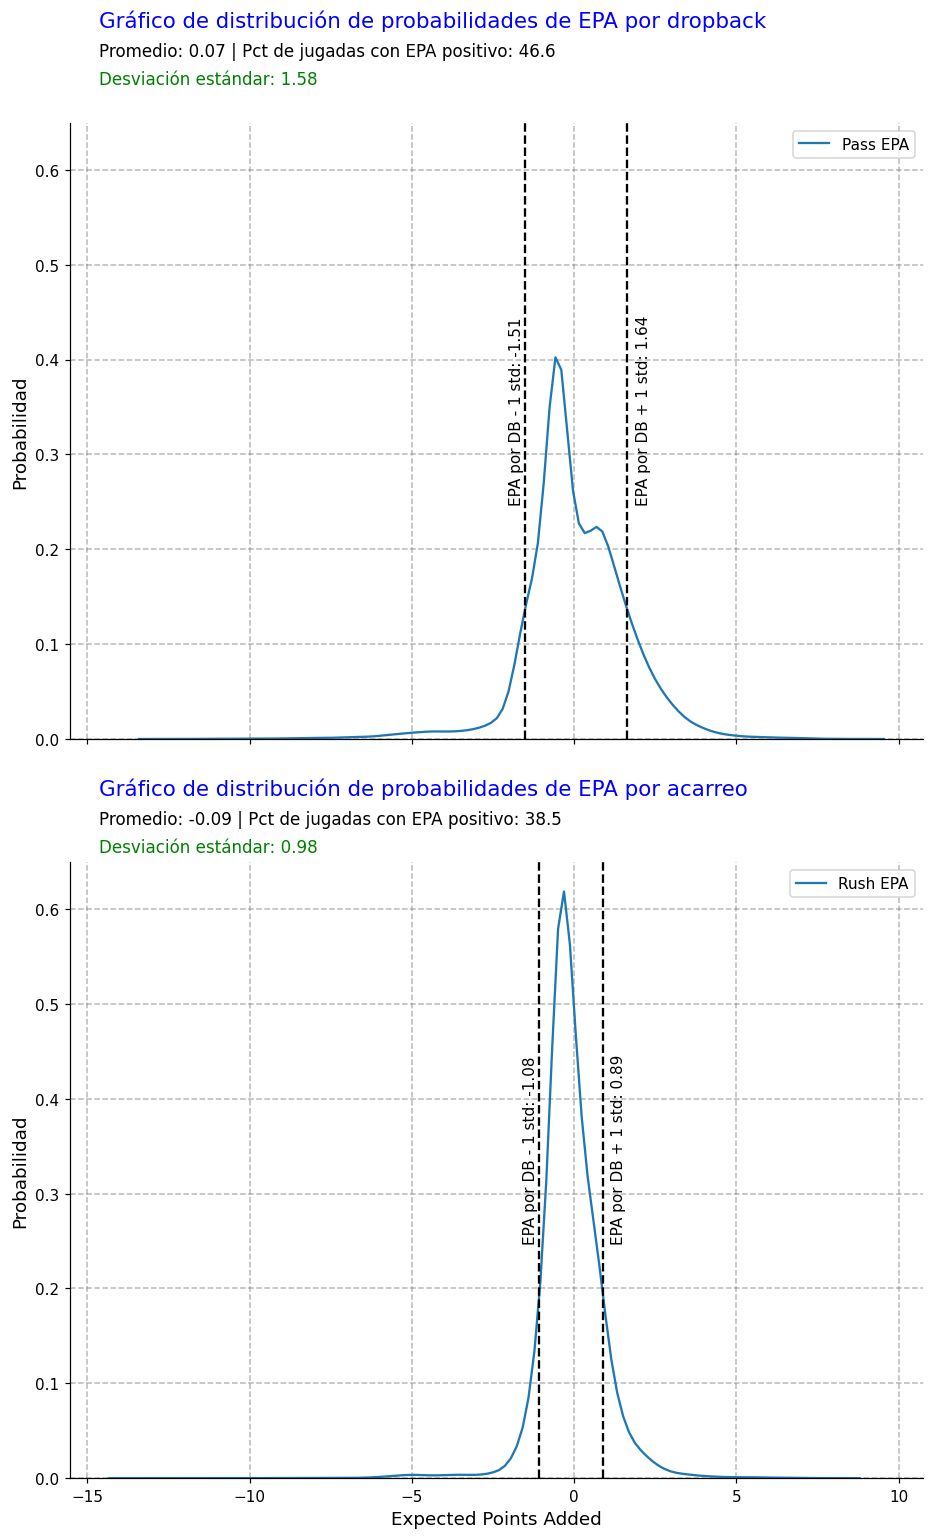

In [393]:
# Figura donde se insertara la grafica
fig= plt.figure()
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,16), dpi=110, sharex=True, sharey=True)

# Formato del contorno de figura y líneas de división de ejes
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.grid(lw = 1, color = "grey", ls='--', alpha=0.55)

# Formato del contorno de figura y líneas de división de ejes
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.grid(lw = 1, color = "grey", ls='--', alpha=0.55)

# Creamos un dataframe por si queremos instalar algun filtro extra
plot = data1

# Creamos una variable para guardar el EPA de todos los pases en la NFL
pass_epa = plot[plot['pass']==1]['epa']

# Desviación estándar
pass_std = round(pass_epa.std(),2)

# Success en pases
success_pass = plot[plot['pass']==1]['success'].mean()*100

# Creamos una variable para guardar el EPA de todos los acarreos en la NFL 
rush_epa = plot[plot['rush']==1]['epa']

# Desviación estándar
rush_std = round(rush_epa.std(),2)

#Sucess en acarreos
success_rush = plot[plot['rush']==1]['success'].mean()*100

# Gráfico de distribución del EPA de los pases
sns.kdeplot(pass_epa, bw=0.25, label='Pass EPA', ax= ax1)

# Gráfico de distribución del EPA de los acarreos
sns.kdeplot(rush_epa, bw=0.25, label='Rush EPA', ax= ax2)

# Líneas que indican la media de EPA +/- una desvición estándar de los pases
ax1.axvline(pass_epa.mean()-pass_epa.std(), ls='--', color='black')
ax1.axvline(pass_epa.mean()+pass_epa.std(), ls='--', color='black')

# Insertmos el nombre de las líneas 
ax1.text(pass_epa.mean()-pass_epa.std()-0.5, 0.25, s=f'EPA por DB - 1 std: {(pass_epa.mean()-pass_epa.std()).round(2)}', rotation=90)
ax1.text(pass_epa.mean()+pass_epa.std()+0.25, 0.25, s=f'EPA por DB + 1 std: {(pass_epa.mean()+pass_epa.std()).round(2)}', rotation=90)

# Líneas que indican la media +/- una desviación estándar de los acarreos
ax2.axvline(rush_epa.mean()-rush_epa.std(), ls='--', color='black')
ax2.axvline(rush_epa.mean()+rush_epa.std(), ls='--', color='black')

# Insertamos el nombre de las líneas.
ax2.text(rush_epa.mean()-rush_epa.std()-0.5, 0.25, s=f'EPA por DB - 1 std: {(rush_epa.mean()-rush_epa.std()).round(2)}', rotation=90)
ax2.text(rush_epa.mean()+rush_epa.std()+0.25, 0.25, s=f'EPA por DB + 1 std: {(rush_epa.mean()+rush_epa.std()).round(2)}', rotation=90)

# Títulos y subtítulos del primer gráfico
ax1.text(pass_epa.min()-2, 0.75, s='Gráfico de distribución de probabilidades de EPA por dropback', fontsize=14, color='blue')
ax1.text(pass_epa.min()-2, 0.72, s=f'Promedio: {pass_epa.mean().round(2)} | Pct de jugadas con EPA positivo: {success_pass.round(1)}', fontsize=11)
ax1.text(pass_epa.min()-2, 0.69, s=f'Desviación estándar: {pass_std}', fontsize=11, color='green')

# Títulos y subtítulos del primer gráfico
ax2.text(pass_epa.min()-2, 0.72, s='Gráfico de distribución de probabilidades de EPA por acarreo', fontsize=14, color='blue')
ax2.text(pass_epa.min()-2, 0.69, s=f'Promedio: {rush_epa.mean().round(2)} | Pct de jugadas con EPA positivo: {success_rush.round(1)}', fontsize=11)
ax2.text(pass_epa.min()-2, 0.66, s=f'Desviación estándar: {rush_std}', fontsize=11, color='green')

# Título de ejes gráfico 1
ax1.set_ylabel('Probabilidad', fontsize=12)

# Título de ejes gráfico 2
ax2.set_xlabel('Expected Points Added', fontsize=12)
ax2.set_ylabel('Probabilidad', fontsize=12)

# Eficiencia por tipo de jugada pt. III

- En los gráficos de distribución podemos observar lo que ya señalabamos en el gráfico de cajas y bigotes:
    - Las jugadas de pase, en promedio, suelen generar más eficiencia que los acarreos:
        - Success rate: 46.6 vs 38.5
        - Media: 0.07 vs -0.09
    - Sin embargo, los acarreos son una jugada menos riesgosa:
        - El 50% de los acarreos produce una eficiencia de entre -0.52 y 0.36
        - El 50% de los pases produce una eficiencia de -0.74 y 0.98
        - La desviación estandar de EPA para un acarreo es de 0.98
        - La desviación estándar de EPA para un pase es de 1.58
        
- El diferencial de llamadas de pase y acarreos esta justificado por el diferencial de eficiencia

- El ratio de pases/acarreos en los últimos años ha sido estable, lo que podría indicarnos que la eficiencia de pase durante esos años también lo ha sido.

Text(2011.5, 0.115, 'La eficiencia por pase ha sido estable, salvo en 2017 y 2020')

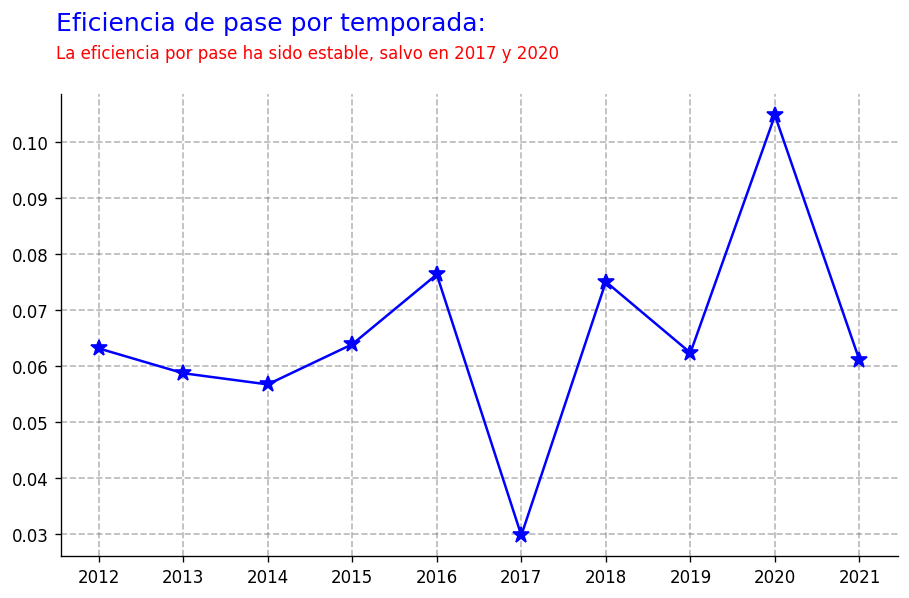

In [413]:
# Gráfico de eficiencia por pase

#Figura donde se insertara la grafica
fig= plt.figure(figsize= (9,5), dpi= 120)
ax= plt.subplot(111, facecolor= "white")

# Formato del contorno de figura y líneas de división de ejes
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.grid(lw = 1, color = "grey", ls='--', alpha=0.55)

# Agrupamos la eficiencia de pase por temporada

passes = data1[data1['pass']==1].groupby(['season'])['epa'].mean().reset_index()


# Generamos una variable para guardar el EPA/db por temporada

pass_epa = passes['epa'].reset_index(drop=True)

# Gneramos una variable X

x = passes['season'].reset_index(drop=True)

# Código de gráfico de línea

ax.plot(x, pass_epa, color='blue', lw=1.5, marker='*', ms=10)

# Formato de ubicación de las etiquetas 

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

# Título de la gráfica

ax.text(2011.5, 0.12, s='Eficiencia de pase por temporada:', fontsize=15, color='blue')
ax.text(2011.5, 0.115, s='La eficiencia por pase ha sido estable, salvo en 2017 y 2020', fontsize=10, color='red')
